In [1]:
import pandas as pd
import torch
import torch.nn as nn

# Load data
df = pd.read_csv('xor.csv')
df.head()


,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0


In [2]:
# Use scikit-learn to split the data into training, validation, and test sets: 75%, 10%, 15%
from sklearn.model_selection import train_test_split
X = df[['x1', 'x2']].values
y = df['class label'].values

# Train and test split from whole data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1, stratify = y, shuffle = True)
# Obtain validation set from training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1, stratify = y_train, shuffle=True)

# Print the shape of the training, validation, and test sets
print("Training set: ", X_train.shape, "percentage: ", X_train.shape[0]/X.shape[0])
print("Validation set: ", X_val.shape, "percentage: ", X_val.shape[0]/X.shape[0])
print("Test set: ", X_test.shape, "percentage: ", X_test.shape[0]/X.shape[0])

Training set:  (573, 2) percentage:  0.764
Validation set:  (64, 2) percentage:  0.08533333333333333
Test set:  (113, 2) percentage:  0.15066666666666667


## Visualizing the data

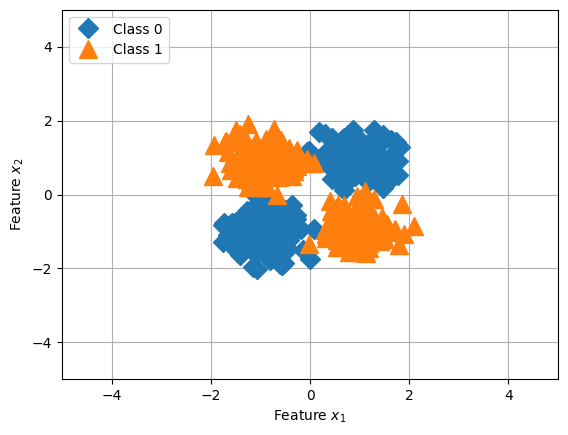

In [12]:
import matplotlib.pyplot as plt
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker = "D",
    markersize = 10,
    linestyle = "",
    label = "Class 0"
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker = "^",
    markersize = 13,
    linestyle = "",
    label = "Class 1"
)
plt.legend(loc = "upper left")
plt.xlabel("Feature $x_1$")
plt.ylabel("Feature $x_2$")

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.grid()

## Implement the Model i.e multilayer perceptron

In [32]:
import torch
import torch.nn as nn

class PyTorchMLP(nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(

            # First hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # Output layer
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        # Pass data through all layers
        logits = self.all_layers(x)
        return logits

## Define  Datasets and DataLoaders

torch_dataset: An abstraction that represents a collection of data and provides a consistent interface to access data, preprocess and transform it on the fly. A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

__init__: Set up attributes to use in __getitem__

__getitem__: Defines how to load a single data item given its index

__len__: Returns the total number of data items in the dataset

torch_dataloader: The primary purpose of the dataloader is to provide batches of data to the model.

Quickly check: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


In [21]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):

    def __init__(self, X, y): # Typically initialized with data and labels, and transform
        self.features = torch.tensor(X, dtype = torch.float32)
        self.labels = torch.tensor(y, dtype = torch.int64)

    def __getitem__(self, index): # The __getitem__ function loads and returns a sample from the dataset at the given index idx.
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self): # returns the number of samples in our dataset.
        return len(self.labels)

# Create training, validation, and test datasets
train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

# Create training, validation, and test dataloaders to load data in batches for model training
train_dl = DataLoader(
    dataset = train_ds,
    batch_size = 32,
    shuffle = True,
    
)

val_dl = DataLoader(
    dataset = val_ds,
    batch_size = 32,
    shuffle = False
)

test_dl = DataLoader(
    dataset = test_ds,
    batch_size = 32,
    shuffle = False
)

## Define the training loop

In [26]:
# Utility function to calculate accuracy
def compute_accuracy(model, data_loader):

    correct, total_examples = 0.0, 0.0

    # Put the model in eval mode
    model = model.eval()

    for idx, (features, targets) in enumerate(data_loader): # Good practice to enumerate over data_loader 

        with torch.inference_mode(): # Turn off gradient computation aka torch.no_grad()
            logits = model(features)
            
        # Get predictions from the model
        predicted_labels = torch.argmax(logits, dim = 1)

        # Count number of correct predictions
        correct += torch.sum((predicted_labels == targets).float())

        # Count the total number of examples
        total_examples += len(targets)

    # Compute the accuracy
    accuracy = correct/total_examples

    return accuracy

In [34]:
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
model = PyTorchMLP(num_features = 2, num_classes = 2)
optimizer = optim.SGD(model.parameters(), lr = 0.05)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):

    # Put model in training mode
    model = model.train()

    # Iterate over the mini-batches
    for idx, (features, labels) in enumerate(train_dl):

        # Forward pass
        logits = model(features)

        # Compute loss
        loss = F.cross_entropy(logits, labels) # Pytorch does softmax internally

        # Zero out the gradients from the previous iteration
        optimizer.zero_grad()

        # Compute gradients wrt to loss
        loss.backward()

        # Update parameters
        optimizer.step()

        # Logging
        #print(f"\nEpoch: {epoch + 1} / {num_epochs}, \nBatch {idx + 1} / len(train_dl), \nLoss: {loss.item():.4f}")

    # Compute train and validation accuracy
    train_acc = compute_accuracy(model, train_dl)
    val_acc = compute_accuracy(model, val_dl)
    print(f"\nEpoch: {epoch + 1} / {num_epochs}, \nTrain acc: {train_acc:.4f}, \nValidation acc: {val_acc:.4f}")



Epoch: 1 / 10, 
Train acc: 0.6841, 
Validation acc: 0.6562

Epoch: 2 / 10, 
Train acc: 0.8150, 
Validation acc: 0.7344

Epoch: 3 / 10, 
Train acc: 0.8988, 
Validation acc: 0.9062

Epoch: 4 / 10, 
Train acc: 0.9319, 
Validation acc: 0.9062

Epoch: 5 / 10, 
Train acc: 0.9529, 
Validation acc: 0.9219

Epoch: 6 / 10, 
Train acc: 0.9476, 
Validation acc: 0.9219

Epoch: 7 / 10, 
Train acc: 0.9686, 
Validation acc: 0.9844

Epoch: 8 / 10, 
Train acc: 0.9703, 
Validation acc: 1.0000

Epoch: 9 / 10, 
Train acc: 0.9808, 
Validation acc: 1.0000

Epoch: 10 / 10, 
Train acc: 0.9825, 
Validation acc: 1.0000


## Evaluate the model on test data

In [38]:
train_acc = compute_accuracy(model, train_dl)
val_acc = compute_accuracy(model, val_dl)
test_acc = compute_accuracy(model, test_dl)

print(f"\nTrain acc: {train_acc:.4f}, \nValidation acc: {val_acc:.4f}, \nTest acc: {test_acc:.4f}")


Train acc: 0.9825, 
Validation acc: 1.0000, 
Test acc: 0.9912


## Moving on to a more complex dataset: MNIST

### Loading the dataset

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

train_ds = datasets.MNIST(
    root = "./mnist", train = True, transform = transforms.ToTensor(), download = True
)
# transforms.ToTensor() converts the image into numbers and scales the values between 0 and 1

test_ds = datasets.MNIST(
    root = "./mnist", train = False, transform = transforms.ToTensor(), download = True
)

In [3]:
len(train_ds), len(test_ds)

(60000, 10000)

In [6]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import random_split # random_split splits a torch dataset into new datasets
## Create a validation set from the training set
torch.manual_seed(1)

train_ds, val_ds = random_split(train_ds, [55000, 5000])

In [7]:
# Create training, validation, and test dataloaders to load data in batches for model training
train_dl = DataLoader(
    dataset = train_ds,
    batch_size = 64,
    shuffle = True,
)

val_dl = DataLoader(
    dataset = val_ds,
    batch_size = 64,
    shuffle = False
)   

test_dl = DataLoader(
    dataset = test_ds,
    batch_size = 64,
    shuffle = False
)   



Always a good practice to look at the distribution of labels in the dataset 

In [8]:
from collections import Counter

train_counter = Counter()
for images, labels in train_dl:
    train_counter.update(labels.tolist())
print(f"\nTraining label distribution, \n{sorted(train_counter.items())}")

val_counter = Counter()
for images, labels in val_dl:
    val_counter.update(labels.tolist())
print(f"\nValidation label distribution, \n{sorted(val_counter.items())}")

test_counter = Counter()
for images, labels in test_dl:
    test_counter.update(labels.tolist())
print(f"\nTest label distribution, \n{sorted(test_counter.items())}")



Training label distribution, 
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution, 
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution, 
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


## Zero-rule classifier / majority class classifier

If we were only predicting the majority class, what would our accuracy be?

In [16]:
majority_class = test_counter.most_common(1)[0]
print(f"\nMajority class: {majority_class[0]}")

baseline_accuracy = majority_class[1]/sum(test_counter.values())
print(f"\nBaseline accuracy: {baseline_accuracy*100:.2f}%")


Majority class: 1

Baseline accuracy: 11.35%


## Visual check

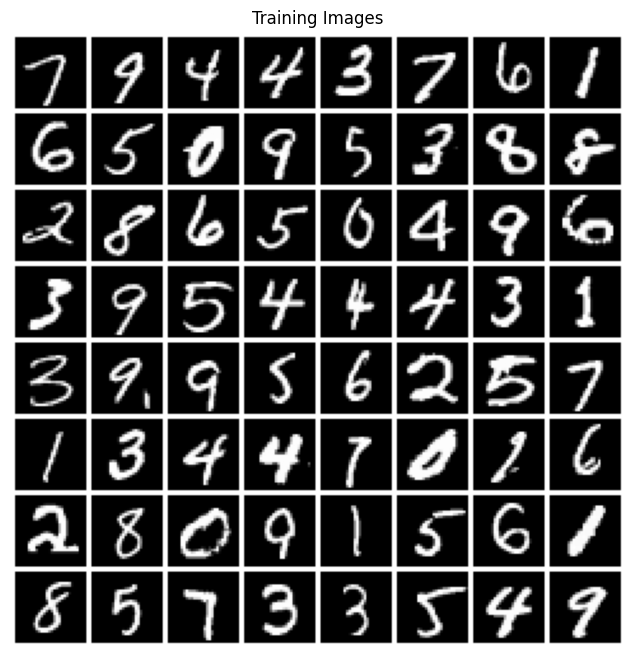

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images, labels in train_dl:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(torchvision.utils.make_grid(images, nrow = 8, normalize=True, pad_value=1).permute(1, 2, 0))

## Implement the model i.e multilayer perceptron

In [39]:
import torch
import torch.nn as nn

class PyTorchMLP(nn.Module):

    # Initialize the class
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes)
        )

    # Forward the data through all layers
    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        logits = self.all_layers(x)
        return logits
    

### Training loop

In [40]:
# Utility function to compute accuracy
def compute_accuracy(model, dataloader):

    correct, total_examples = 0.0, 0.0
    
    # Put the model in eval mode
    model = model.eval()

    for idx, (features, targets) in enumerate(dataloader):

        with torch.inference_mode():
            logits = model(features)
        
            # Get predictions from the model
            predicted_labels = torch.argmax(logits, dim = 1)

            # Count number of correct predictions
            correct += torch.sum((predicted_labels == targets).float())

            # Count the total number of examples
            total_examples += len(targets)

    # Compute the accuracy
    accuracy = correct/total_examples

    return accuracy

import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
model = PyTorchMLP(num_features = 784, num_classes = 10)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
num_epochs = 10
loss_list = []
train_acc_list, val_acc_list = [], []

# Training loop
for epoch in range(num_epochs):

    # Put the model in training mode
    model = model.train()

    # Iterate over the mini-batches
    for batch_idx, (features, labels) in enumerate(train_dl):

        # Forward pass
        logits = model(features)

        # Compute loss
        loss = F.cross_entropy(logits, labels)

        # Zero out the gradients from the previous iteration
        optimizer.zero_grad()

        # Compute gradients wrt to loss
        loss.backward()

        # Update parameters
        optimizer.step()

    loss_list.append(loss.item())

    # Compute train and validation accuracy for each epoch
    train_acc = compute_accuracy(model, train_dl)
    train_acc_list.append(train_acc)
    val_acc = compute_accuracy(model, val_dl)
    val_acc_list.append(val_acc)
    print(f"\nEpoch: {epoch + 1} / {num_epochs}, \nTrain acc: {train_acc:.4f}, \nValidation acc: {val_acc:.4f}")


Epoch: 1 / 10, 
Train acc: 0.8870, 
Validation acc: 0.8822

Epoch: 2 / 10, 
Train acc: 0.9184, 
Validation acc: 0.9112

Epoch: 3 / 10, 
Train acc: 0.9371, 
Validation acc: 0.9286

Epoch: 4 / 10, 
Train acc: 0.9480, 
Validation acc: 0.9354

Epoch: 5 / 10, 
Train acc: 0.9547, 
Validation acc: 0.9436

Epoch: 6 / 10, 
Train acc: 0.9572, 
Validation acc: 0.9466

Epoch: 7 / 10, 
Train acc: 0.9606, 
Validation acc: 0.9516

Epoch: 8 / 10, 
Train acc: 0.9648, 
Validation acc: 0.9496

Epoch: 9 / 10, 
Train acc: 0.9701, 
Validation acc: 0.9548

Epoch: 10 / 10, 
Train acc: 0.9722, 
Validation acc: 0.9562


### Evaluating the model on test data

In [44]:
train_acc = compute_accuracy(model, train_dl)
val_acc = compute_accuracy(model, val_dl)
test_acc = compute_accuracy(model, test_dl)

print(f"\nTrain_acc: {train_acc*100:.2f}%, \nVal_acc: {val_acc*100:.2f}%, \nTest_acc: {test_acc*100:.2f}%")


Train_acc: 97.22%, 
Val_acc: 95.62%, 
Test_acc: 96.41%


## Plotting the loss and accuracy curves

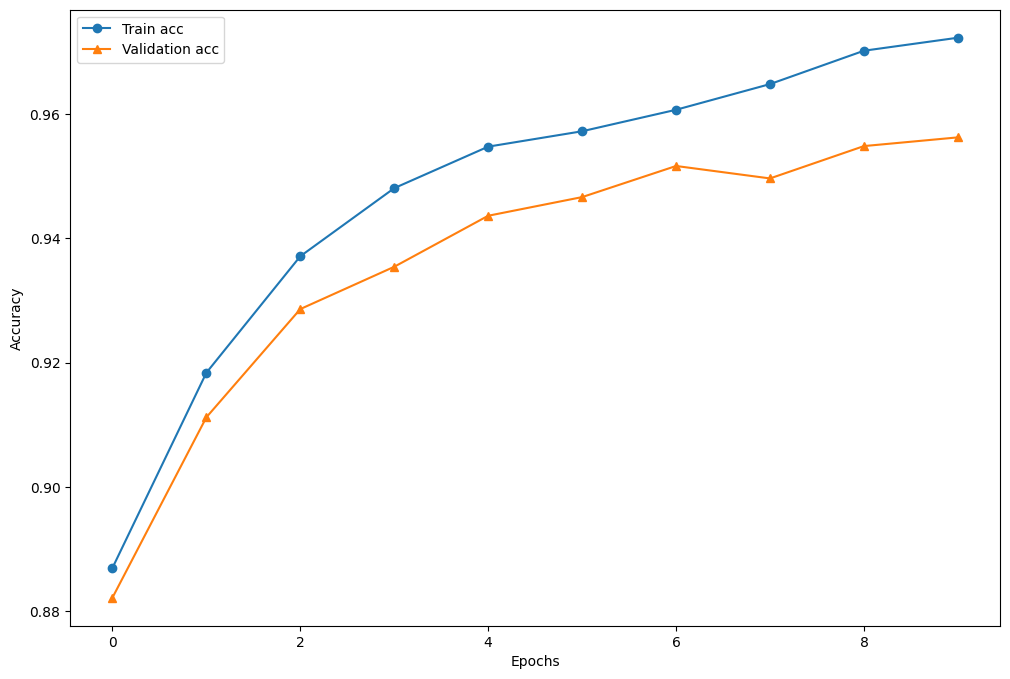

In [49]:
train_acc_list = [t.item() for t in train_acc_list]
val_acc_list = [t.item() for t in val_acc_list]

plt.figure(figsize = (12, 8))
plt.plot(train_acc_list, label = "Train acc", marker = "o")
plt.plot(val_acc_list, label = "Validation acc", marker = "^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

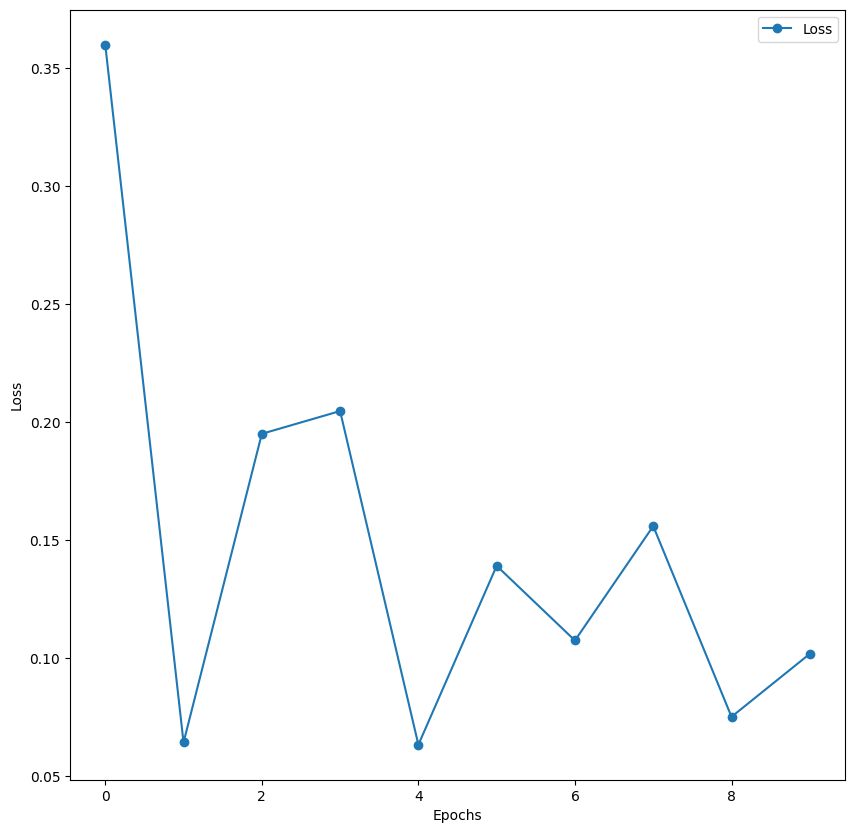

In [51]:
plt.figure(figsize = (10, 10))
plt.plot(loss_list, label = "Loss", marker = "o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Perhaps it would have been better to plot the average loss of all mini-batches in an epoch, rather than the loss of the last mini-batch.

## Using a MLP for regression

To use a MLP for regression, we ensure that the output layer has a single neuron and no activation function. The loss function is the mean squared error.

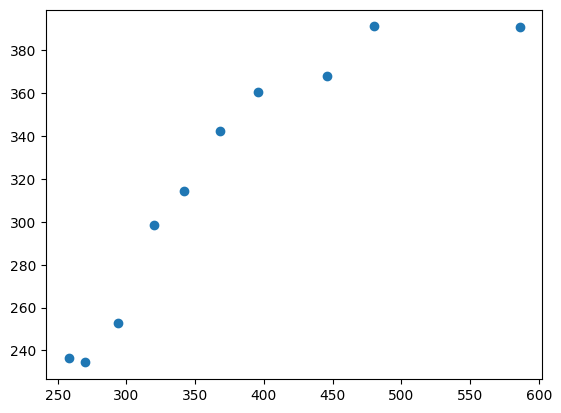

In [59]:
import torch
import matplotlib.pyplot as plt
## Create a simple dataset
X_train = torch.tensor(
   [258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0] 
).view(-1, 1)

y_train = torch.tensor(
    [236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8]
).view(-1, 1)

plt.scatter(X_train, y_train)


torch.view: Reshapes tensors and ensures the new tensor shares the underlying data with the original tensor. It is a very cheap operation and does not require any data copying.

### MLP for regression
Only the output layer changes to have a single neuron.

In [68]:
import torch.nn as nn
class PyTorchMLP_reg(nn.Module):

    def __init__(self, num_features, num_classes = 1):
        super().__init__()

        self.all_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes) ## Only 1 output neuron for regression
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

### Normalize the data - preprocessing

In [63]:
## We normalized the target too?
x_mean, x_std = X_train.mean(dim = 0), X_train.std(dim = 0)
y_mean, y_std = y_train.mean(dim = 0), y_train.std(dim = 0)

X_train_norm = (X_train - x_mean)/x_std
y_train_norm = (y_train - y_mean)/y_std


### Set up the data loader

__init__: Set up attributes to use in __getitem__

__getitem__: Defines how to load a single data item given its index

__len__: Returns the total number of data items in the dataset

In [66]:
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset that inherits from the Dataset class
class MyDataset(Dataset):

    def __init__(self, X, y): # Sets up attributes to be used by other methods
        self.features = X
        self.targets = y

    def __getitem__(self, index): # Defines how to load a single sample from the dataset
        x = self.features[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self): # Returns the number of samples in the dataset
        return len(self.targets)

# Define datasets and dataloaders 
train_ds = MyDataset(X_train_norm, y_train_norm)
train_dl = DataLoader(
    dataset = train_ds,
    batch_size = 20,
    shuffle = True,
)

### Train Model

In [69]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP_reg(num_features=1, num_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

num_epochs = 30

loss_list = []
for epoch in range(num_epochs):

    # Put the model in training mode
    model = model.train()

    # Iterate over the mini-batches
    for batch_idx, (features, targets) in enumerate(train_dl):

        # Forward pass
        logits = model(features)

        # Compute loss
        loss = F.mse_loss(logits, targets)

        # Zero out the gradients from the previous iteration
        optimizer.zero_grad()

        # Compute gradients wrt to loss
        loss.backward()

        # Update parameters
        optimizer.step()

    loss_list.append(loss.item())
    print(f"Epoch: {epoch + 1} / {num_epochs}, Loss: {loss.item():.4f}")

Epoch: 1 / 30, Loss: 0.8614
Epoch: 2 / 30, Loss: 0.6336
Epoch: 3 / 30, Loss: 0.4533
Epoch: 4 / 30, Loss: 0.2940
Epoch: 5 / 30, Loss: 0.1781
Epoch: 6 / 30, Loss: 0.1136
Epoch: 7 / 30, Loss: 0.0835
Epoch: 8 / 30, Loss: 0.0698
Epoch: 9 / 30, Loss: 0.0614
Epoch: 10 / 30, Loss: 0.0549
Epoch: 11 / 30, Loss: 0.0493
Epoch: 12 / 30, Loss: 0.0443
Epoch: 13 / 30, Loss: 0.0400
Epoch: 14 / 30, Loss: 0.0362
Epoch: 15 / 30, Loss: 0.0329
Epoch: 16 / 30, Loss: 0.0299
Epoch: 17 / 30, Loss: 0.0273
Epoch: 18 / 30, Loss: 0.0250
Epoch: 19 / 30, Loss: 0.0230
Epoch: 20 / 30, Loss: 0.0212
Epoch: 21 / 30, Loss: 0.0198
Epoch: 22 / 30, Loss: 0.0186
Epoch: 23 / 30, Loss: 0.0177
Epoch: 24 / 30, Loss: 0.0168
Epoch: 25 / 30, Loss: 0.0160
Epoch: 26 / 30, Loss: 0.0152
Epoch: 27 / 30, Loss: 0.0144
Epoch: 28 / 30, Loss: 0.0137
Epoch: 29 / 30, Loss: 0.0131
Epoch: 30 / 30, Loss: 0.0126


### See how the model performs on "test" data

In [70]:
X_range = torch.arange(150, 800, 0.1).view(-1, 1)
X_range_norm = (X_range - x_mean) / x_std

# Put the model in eval mode
model = model.eval()

# Disable gradient computation
with torch.inference_mode():
    y_range_norm = model(X_range_norm)

# Undo normalization to get predictions in the original scale
y_range = y_range_norm * y_std + y_mean

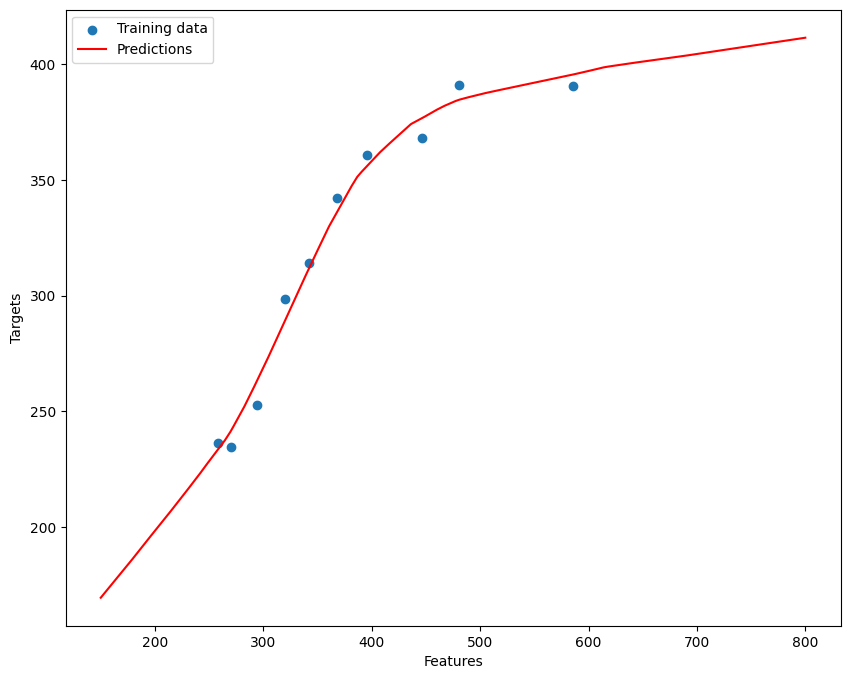

In [71]:
## Plot the predictions
plt.figure(figsize = (10, 8))
plt.scatter(X_train, y_train, label = "Training data")
plt.plot(X_range, y_range, color = "r", label = "Predictions")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.legend()
plt.show()